In [6]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3

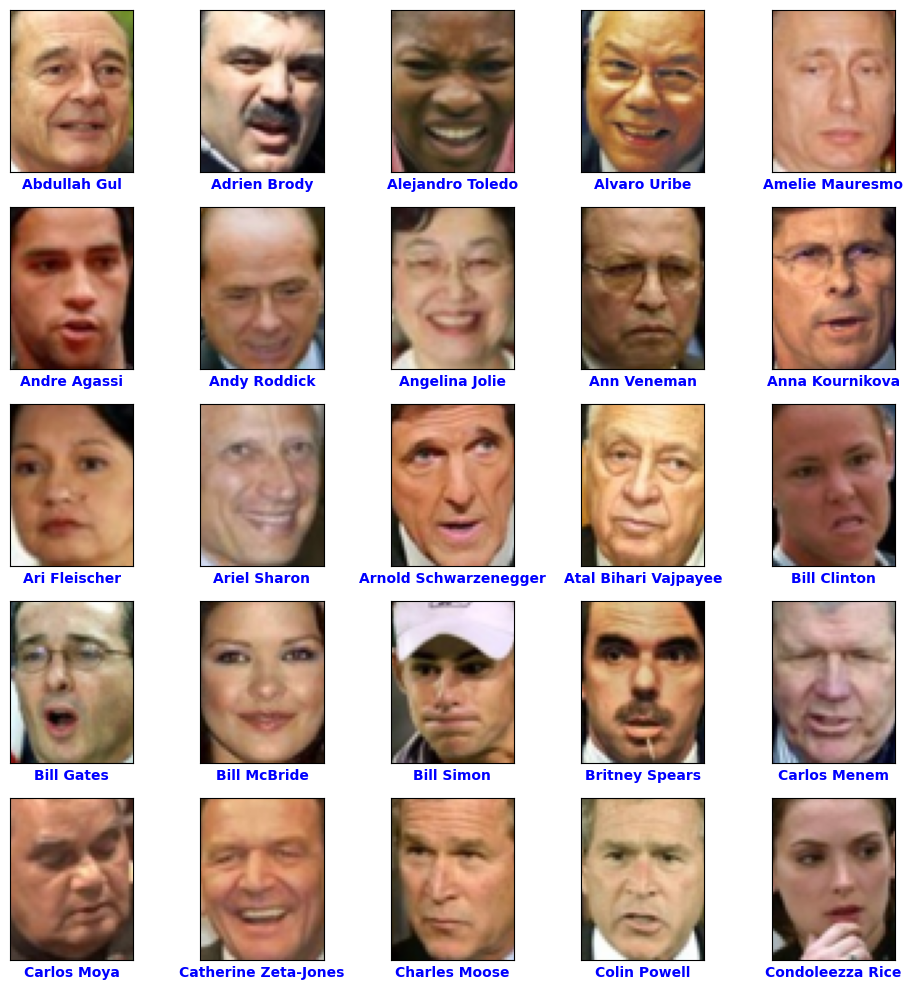

Shape of x (4324, 8742)
Shape of y (4324,)
Shape (4324, 62, 47, 3)
Size 37800408
target_name ['Abdullah Gul' 'Adrien Brody' 'Alejandro Toledo' 'Alvaro Uribe'
 'Amelie Mauresmo'] ... 153 more names are in the target_names array


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=10, download_if_missing=True, color=True)

x = lfw_people.data
y = lfw_people.target
x_images = lfw_people.images
y_labels = lfw_people.target_names

# image details
def image_details():
    images_details = {
        "Shape of x": x.shape,
        "Shape of y": y.shape,
        "Shape": lfw_people.images.shape,
        "Size": lfw_people.images.size,
        "target_name": lfw_people.target_names,
    }

    for k, v in images_details.items():
        if k == "target_name":
            print(k, v[:5], '...', len(v) - 5, 'more names are in the target_names array')
        else:
            print(k, v)

# image plots
def image_plots(x, y):
    fig, ax = plt.subplots(5, 5, figsize=(10, 10))
    for i, axi in enumerate(ax.flat):
        axi.imshow(x[i].reshape(62, 47, 3), cmap=plt.cm.binary)
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(y_labels[i], fontsize=10, fontweight='bold', color='blue')

    plt.tight_layout()
    plt.show()

image_plots(x_images,y_labels)
image_details()


In [3]:
# split data into train and test
x = x.reshape(-1, 62, 47, 3)
print(x.shape)

# Upscale the images to 75x75 using OpenCV
upscaled_images = []
for image in x:
    upscaled_image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_LINEAR)
    upscaled_images.append(upscaled_image)

x_upscaled = np.array(upscaled_images)

x_train, x_test, y_train, y_test = train_test_split(x_upscaled, y, test_size=0.25, random_state=42)
num_samples, height, width, color = x_train.shape
print('Number of samples:', num_samples)
print('Height:', height)
print('Width:', width)
print('Color:', color)

(4324, 62, 47, 3)
Number of samples: 3243
Height: 150
Width: 150
Color: 3


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 conv2d_855 (Conv2D)         (None, 3, 3, 64)          1179712   
                                                                 
 dropout_9 (Dropout)         (None, 3, 3, 64)          0         
                                                                 
 conv2d_856 (Conv2D)         (None, 3, 3, 64)          36928     
                                                                 
 global_average_pooling2d_8   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 158)               10270     
                                                      

2023-07-29 06:23:10.108170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


102/102 [==============================] - 29s 194ms/step - loss: 4.4839 - accuracy: 0.1570 - val_loss: 4.2466 - val_accuracy: 0.2017
Epoch 2/100
102/102 [==============================] - 18s 173ms/step - loss: 3.9644 - accuracy: 0.2186 - val_loss: 3.8615 - val_accuracy: 0.2442
Epoch 3/100
102/102 [==============================] - 19s 182ms/step - loss: 3.5773 - accuracy: 0.2720 - val_loss: 3.7036 - val_accuracy: 0.2775
Epoch 4/100
102/102 [==============================] - 18s 175ms/step - loss: 3.2735 - accuracy: 0.3013 - val_loss: 3.3387 - val_accuracy: 0.3043
Epoch 5/100
102/102 [==============================] - 19s 182ms/step - loss: 2.9977 - accuracy: 0.3361 - val_loss: 3.1137 - val_accuracy: 0.3423
Epoch 6/100
102/102 [==============================] - 17s 170ms/step - loss: 2.7913 - accuracy: 0.3839 - val_loss: 3.0333 - val_accuracy: 0.3552
Epoch 7/100
102/102 [==============================] - 18s 180ms/step - loss: 2.6015 - accuracy: 0.4092 - val_loss: 2.6887 - val_accurac

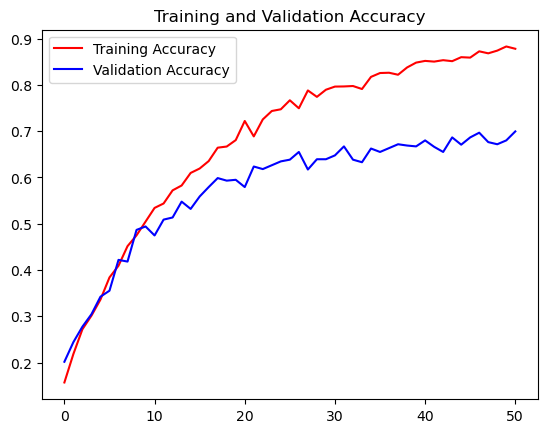

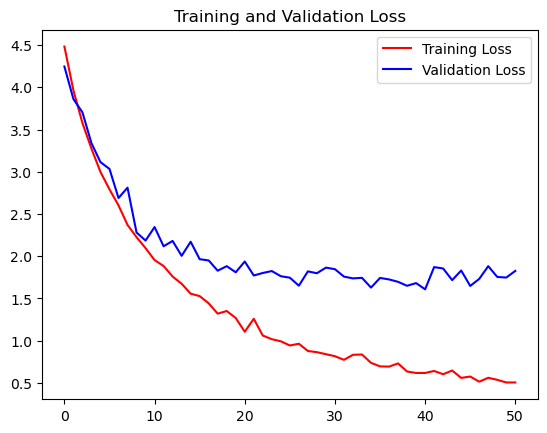

In [15]:
def learn_model(input_shape, num_classes=len(np.unique(y)), dropout_rate=0.5, learning_rate=0.001):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, )
    base_model.trainable = True
    for layer in base_model.layers[:-50]:  # Unfreeze the last 50 layers
        layer.trainable = False


    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the model
model = learn_model((height, width, color))

# Train the model with data augmentation and early stopping
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_test, y_test)

history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Retrieve a list of list results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


34/34 [==============================] - 2s 25ms/step


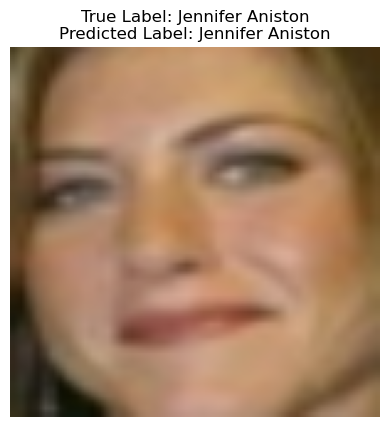

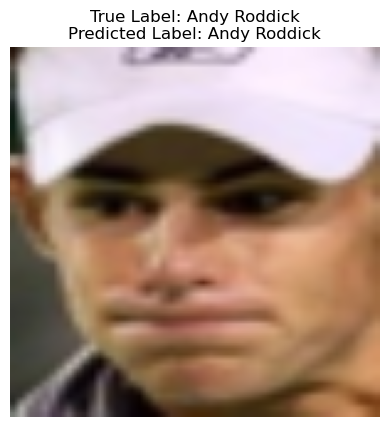

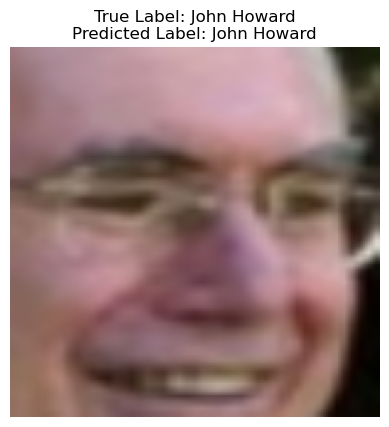

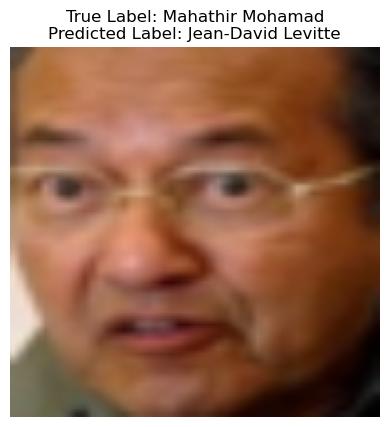

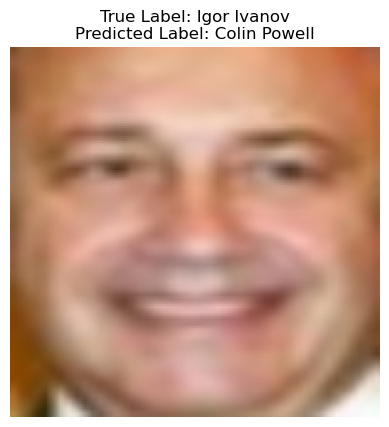

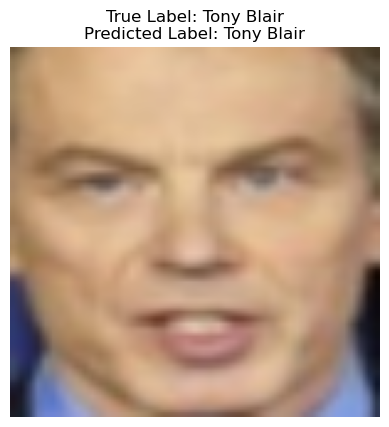

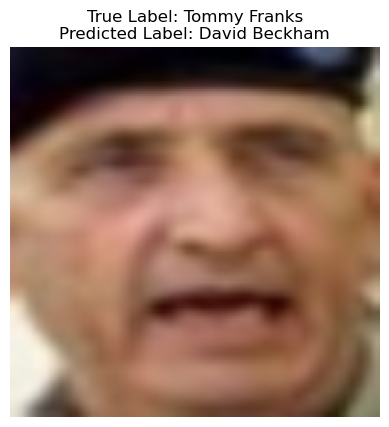

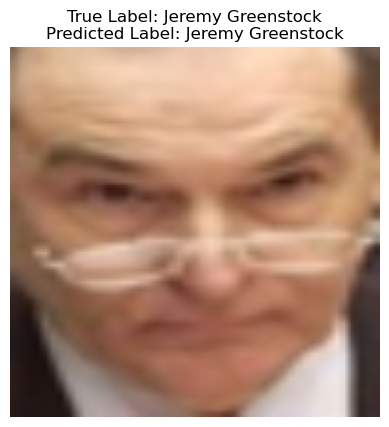

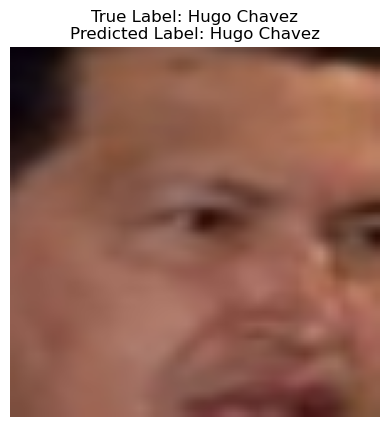

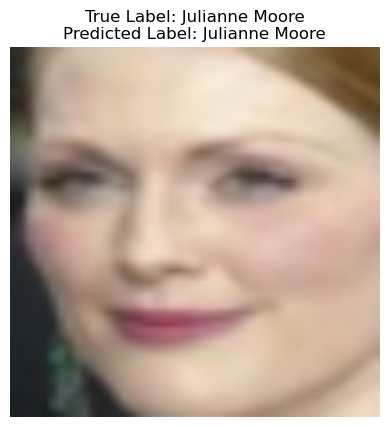

In [16]:
# Make predictions on the test set
y_pred = model.predict(x_test)

# Save the model to the Kaggle output directory
model.save('/kaggle/working/my_model.h5')

# Function to plot a sample image along with the true and predicted labels
def plot_sample_image(image, true_label, predicted_label):
    plt.imshow(image)
    plt.title(f"True Label: {lfw_people.target_names[true_label]}\nPredicted Label: {lfw_people.target_names[predicted_label]}")
    plt.axis('off')
    plt.show()

# Plot the first 10 sample images from the test set
for i in range(10):
    plot_sample_image(x_test[i], y_test[i], np.argmax(y_pred[i]))